In [1]:
# Create viz for example for parameterization of single cell in 3D

In [2]:
!date

Sun Jun 26 23:03:21 PDT 2022


In [3]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage, writers
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMorphing/../tools/common.py'>

In [5]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [6]:
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape)

(202847, 1290)


In [7]:
space = shapespace.ShapeSpace(control)
space.execute(df)
df_sphere, df_dist = space.get_cells_inside_ndsphere_of_radius(return_dist=True)
df_sphere.head()

,shape_mode,mpId,aggtype,alias,structure,CellIds
0,NdSphere,5,avg,STR,AAVS1,"[466246, 466260, 466261, 466262, 466264, 46626..."
1,NdSphere,5,avg,STR,ACTB,"[230792, 230794, 230817, 230844, 230850, 23086..."
2,NdSphere,5,avg,STR,ACTN1,"[524579, 524603, 524679, 524688, 524692, 52469..."
3,NdSphere,5,avg,STR,ATP2A2,"[734388, 734509, 734720, 734722, 734729, 73485..."
4,NdSphere,5,avg,STR,CETN2,"[230809, 230831, 230833, 230843, 230980, 23098..."


In [9]:
gene = "ST6GAL1"
not_ideal_ids = []

In [10]:
CellIds = df_sphere.loc[df_sphere.structure==gene, "CellIds"].values[0]
# Sort CellIds by distance from origin
CellIds = df_dist.loc[CellIds].sort_values("Distance").index.values
CellIds = [c for c in CellIds if c not in not_ideal_ids]
CellId = CellIds[0]
print(gene, CellId)

row = df.loc[CellId]
producer = io.DataProducer(control)
producer.set_row(row)
producer.load_single_cell_data()
producer.align_data()

ST6GAL1 438826


In [11]:
vmin, vmax = control.get_optimal_seg_contrast(gene)

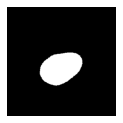

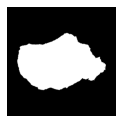

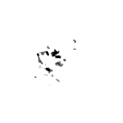

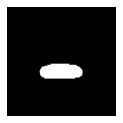

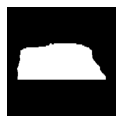

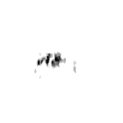

In [13]:
instance_raw = producer.data.copy()[[3, 5, 7]]
instance = producer.data_aligned.copy()[[3, 5, 7]]
for ax in ["z", "y"]:
    proj = common.Projector(instance)
    proj.set_projection_mode(ax=ax, mode={"nuc": "max","mem": "max","gfp": "mean"})
    proj.set_vmin_vmax_gfp_values(vmin, vmax)
    proj.set_gfp_colormap("binary")
    proj.project()

In [14]:
params = {}
for ch, alias in enumerate(["NUC", "MEM"]):
    output = shparam.get_shcoeffs(instance[ch], lmax=32, sigma=2, alignment_2d=False)
    (coeffs, grid_rec), (image_, mesh, grid, transform) = output
    params[alias] = output
    mesh = shtools.get_reconstruction_from_grid(grid_rec, centroid=transform)
skio.imsave(f"FigureMorphing2_3Dcell_nuc_raw.tif", instance_raw[0].astype(np.uint8))
skio.imsave(f"FigureMorphing2_3Dcell_mem_raw.tif", instance_raw[1].astype(np.uint8))
skio.imsave(f"FigureMorphing2_3Dcell_gfp_raw.tif", instance_raw[2].astype(np.uint8))
skio.imsave(f"FigureMorphing2_3Dcell_nuc.tif", instance[0].astype(np.uint8))
skio.imsave(f"FigureMorphing2_3Dcell_mem.tif", instance[1].astype(np.uint8))
skio.imsave(f"FigureMorphing2_3Dcell_gfp.tif", instance[2].astype(np.uint8))

/tmp/ipykernel_23162/97054096.py:9: UserWarning: FigureMorphing2_3Dcell_gfp_raw.tif is a low contrast image
  skio.imsave(f"FigureMorphing2_3Dcell_gfp_raw.tif", instance_raw[2].astype(np.uint8))
/tmp/ipykernel_23162/97054096.py:12: UserWarning: FigureMorphing2_3Dcell_gfp.tif is a low contrast image
  skio.imsave(f"FigureMorphing2_3Dcell_gfp.tif", instance[2].astype(np.uint8))


In [15]:
# Width of the aligned image in µm
print("Width:", 0.108*instance.shape[-1], "µm")

Width: 42.552 µm


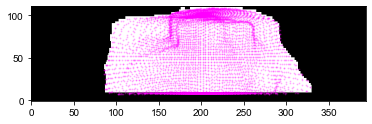

In [16]:
# Validation
from vtk import util as vtkutil
coords = vtkutil. numpy_support.vtk_to_numpy(mesh.GetPoints().GetData())
plt.imshow(instance[1].max(axis=1), cmap="gray", origin="lower")
plt.scatter(coords[:,0],coords[:,2],s=1,color="magenta", alpha=0.2)

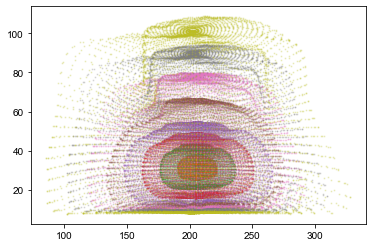

In [17]:
fig, ax = plt.subplots()
grid_mem = params["MEM"][0][1]
grid_nuc = params["NUC"][0][1]
grid_org = np.ones_like(grid_nuc)
rc_mem = np.array(params["MEM"][-1][-1])
rc_nuc = np.array(params["NUC"][-1][-1])
rcis = [rc_nuc]*9
rcfs = [rc_nuc]*5+[rc_mem]*4
gridis = [grid_org]*5+[grid_nuc]*4
gridfs = [grid_nuc]*5+[grid_mem]*4
betas = np.linspace(0,1,5).tolist(); betas += betas[1:]
for betaid, (beta, rci, rcf, gridi, gridf) in enumerate(zip(betas, rcis, rcfs, gridis, gridfs)):
    rc = (1-beta)*rci + beta*rcf
    grid = (1-beta)*gridi + beta*gridf
    mesh = shtools.get_reconstruction_from_grid(grid, centroid=rc)
    coords = vtkutil.numpy_support.vtk_to_numpy(mesh.GetPoints().GetData())
    ax.scatter(coords[:,0],coords[:,2],s=1, alpha=0.2)
    fname = f"FigureMorphing2_mesh_{betaid:02d}.vtk"
    shtools.save_polydata(mesh, fname)
plt.show()

### Mean shape reconstruction

In [18]:
space = shapespace.ShapeSpaceBasic(control)
variables = control.get_variables_values_for_aggregation()
df = space.get_aggregated_df(variables).drop(columns=["structure"]).drop_duplicates().reset_index(drop=True)
df = df.loc[df.mpId==control.get_center_map_point_index()].head(1)
df

,shape_mode,mpId,aggtype,alias
4,NUC_MEM_PC1,5,avg,STR


In [19]:
row = df.loc[df.index[0]]
device = io.LocalStagingIO(control)
device.row = row

In [20]:
nisos = control.get_number_of_interpolating_points()
inner_alias = control.get_inner_most_alias_to_parameterize()
inner_mesh = device.read_map_point_mesh(inner_alias)
outer_alias = control.get_outer_most_alias_to_parameterize()
outer_mesh = device.read_map_point_mesh(outer_alias)
domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])

In [21]:
domain_nuc = (255*(domain>1)).astype(np.uint8)
domain_mem = (255*(domain>0)).astype(np.uint8)

In [22]:
(_, _), (_, _, grid_nuc, transform_nuc) = shparam.get_shcoeffs(domain_nuc, lmax=32, sigma=0, alignment_2d=False)
(_, _), (_, _, grid_mem, transform_mem) = shparam.get_shcoeffs(domain_mem, lmax=32, sigma=0, alignment_2d=False)

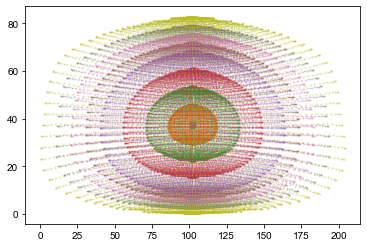

In [23]:
fig, ax = plt.subplots()
grid_org = np.ones_like(grid_nuc)
rc_mem = np.array(transform_mem)
rc_nuc = np.array(transform_nuc)
rcis = [rc_nuc]*9
rcfs = [rc_nuc]*5+[rc_mem]*4
gridis = [grid_org]*5+[grid_nuc]*4
gridfs = [grid_nuc]*5+[grid_mem]*4
betas = np.linspace(0,1,5).tolist(); betas += betas[1:]
for betaid, (beta, rci, rcf, gridi, gridf) in enumerate(zip(betas, rcis, rcfs, gridis, gridfs)):
    rc = (1-beta)*rci + beta*rcf
    grid = (1-beta)*gridi + beta*gridf
    mesh = shtools.get_reconstruction_from_grid(grid, centroid=rc)
    coords = vtkutil.numpy_support.vtk_to_numpy(mesh.GetPoints().GetData())
    ax.scatter(coords[:,0],coords[:,2],s=1, alpha=0.2)
    fname = f"FigureMorphing2_mesh_meanshape_{betaid:02d}.vtk"
    shtools.save_polydata(mesh, fname)
plt.show()

### Load the PILR of corresponding cell and generate morphed cell

In [24]:
rep = device.read_parameterized_intensity_of_alias(CellId, "STR")
print(CellId, rep.shape)

438826 (65, 8194)


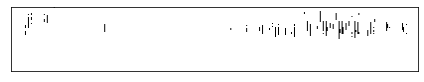

In [25]:
fig, ax = plt.subplots(1,1)
ax.imshow(rep[:,::20], cmap="binary", vmin=0, vmax=255, origin="lower")
ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout()
fname = f"FigureMorphing2_rep_full.png"
plt.savefig(fname, dpi=150)
plt.show()

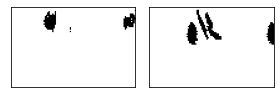

In [26]:
n=1000
fig, axs = plt.subplots(1,2, figsize=(4,4))
axs[0].imshow(rep[:,500:600], cmap="binary", vmin=0, vmax=255, origin="lower")
axs[1].imshow(rep[:,6500:6600], cmap="binary", vmin=0, vmax=255, origin="lower")
[ax.set_xticks([]) for ax in axs]
[ax.set_yticks([]) for ax in axs]
plt.tight_layout()
fname = f"FigureMorphing2_rep.png"
plt.savefig(fname, dpi=150)
plt.show()

In [27]:
coords_mean_shape, _ = cytoparam.parameterize_image_coordinates(
    seg_mem=domain_mem,
    seg_nuc=domain_nuc,
    lmax=16,
    nisos=[32, 32]
)

In [28]:
morphed = cytoparam.morph_representation_on_shape(
    img=domain,
    param_img_coords=coords_mean_shape,
    representation=rep
)

In [29]:
instance = np.stack([domain_nuc, domain_mem, morphed], axis=0)

In [30]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMorphing/../tools/common.py'>

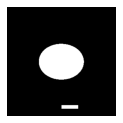

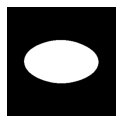

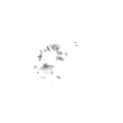

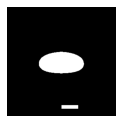

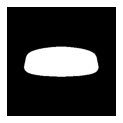

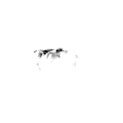

In [33]:
mode = {
    "nuc": "max",
    "mem": "max",
    "gfp": "mean"
}
for ax in ["z", "y"]:
    proj = common.Projector(instance)
    proj.set_projection_mode(ax=ax, mode=mode)
    proj.set_vmin_vmax_gfp_values(vmin, vmax)
    proj.set_gfp_colormap("binary")
    proj.project(save=f"FigureMorphing2_3Dcell_morphed_{ax}", scale_bar={"pixel_size":0.108, "length":5})

In [34]:
common.now("Complete @")

Complete @ 2022-06-26 23:13:29
